# Differential Privacy

In [3]:
import pandas as pd, numpy as np, seaborn as sns
import matplotlib.pyplot as plt

## Attack model

We have studied privacy attacks where attackers learn sensitive information about an individual by linking two (or more) published data sources. What if the datasets are not published? For example, imagine a situation where a hospital dataset is created, as shown below, where anyone can query it to learn aggregated statistics (e.g., "how many people suffer from obesity?") but the actual dataset is never released.

In [7]:
health=pd.read_csv('health.csv')[['Name', 'SSN', 'Marital status', 'Sex', 'DOB', 'Zip', 'Ethnicity', 'Problem' ]]
health[['Marital status', 'Sex', 'Zip', 'Ethnicity', 'Problem' ]]

,Marital status,Sex,Zip,Ethnicity,Problem
0,Divorced,Male,2139,Asian,Hypertension
1,Divorced,Female,2139,Asian,Obesity
2,Married,Female,2139,Asian,Chest pain
3,Married,Female,2139,Asian,Obesity
4,Married,Male,2148,Black,Hypertension
5,Married,Male,2138,Black,Shortness of breath
6,Married,Female,2141,Black,Shortness of breath
7,Married,Male,2141,Black,Obesity
8,Single,Female,2138,White,Chest pain
9,Single,Male,2138,White,Obesity


You know that your neighbor Igor goes to the same hospital. You know Igor's Ethnicity (and obviously, Zip, marital status, and gender!). Assume that the database owner removed any direct identifiers or does not allow quering using them (e.g.,  you cannot ask "what medical problems people have who are named 'Igor'?" Can you learn, by quering the dataset, and not by directly accessing it, what medical problem Igor is suffering from? 

The answer is, unfortunately, **Yes**, which is why we have this chapter.  Before looking into how, lets learn about the concept of `Neighboring datasets`.

### Neighboring datasets
Two datasets $D_1$ and $D_2$ are neighbors if they differ in at most one record (i.e., one row). Thus, either $D_1$ has at most one more (or less) row than $D_2$, or at most one row in $D_1$ has values that are different than $D_2$. We write $|D_1 - D_2|\leq 1$

```{image} neighbor-datasets.png
:height: 150px
:name: neighbor-datasets

Neighboring datasets
```

For example, in {ref}`figure <neighbor-datasets>`, $D_2$ can be obtained by deleting one row from $D_1$ (or $D_1$ can be obtained by adding one row to $D_2$) and thus they are neighbors. $D_1$ and $D_3$ has the same number of rows, but the values in (exactly) one row is different, thus they are also neighbors. Note that, you can obtain $D_3$ by first deleting the last row from $D_1$ and then adding one row in the resulting dataset; thus, this replacement operation can be thought of as a combination of a deletion and an addition operations (i.e., two operations in total).

Imagine that you can only query about the average salary of a set of people in that dataset. Can you learn individual's salary? Yes! By doing some arithmetic manipulations, you can learn `P3`'s salary by querying the average salary from $D_1$ and $D_2$.

Similarly, for the health dataset above, we can construct intermediate neighbor datasets to query from and learn about individuals. Let's say Igor's record is in the $9^{th}$ row. Consider the following neighoboring datasets.

In [16]:
health[health.Problem=='Obesity']

,Name,SSN,Marital status,Sex,DOB,Zip,Ethnicity,Problem
1,--,--,Divorced,Female,1996-06-27,2139,Asian,Obesity
3,--,--,Married,Female,1996-09-22,2139,Asian,Obesity
7,--,--,Married,Male,1995-07-23,2141,Black,Obesity
9,--,--,Single,Male,1995-02-18,2138,White,Obesity


In [17]:
health[(health.Problem=='Obesity') & (health.Ethnicity!='White')]

,Name,SSN,Marital status,Sex,DOB,Zip,Ethnicity,Problem
1,--,--,Divorced,Female,1996-06-27,2139,Asian,Obesity
3,--,--,Married,Female,1996-09-22,2139,Asian,Obesity
7,--,--,Married,Male,1995-07-23,2141,Black,Obesity


Of course these dataset are not observable by the attackers. But they can query, how many people suffer from `Obesity` in total (the first dataset) and people who are not white (remeber that the attacker knows Igor's race and other information). If the difference is $1$, they know that Igor has Obesity! If it is more than $1$, they can narrow down the result by adding more parameters (like sex, zip, etc.) The attacker can repeat the same steps with other medical problems, and Igor must have at least one of them.

**How to prevent such differencing attacks?**

**Differential Privacy** is the answer. Let's learn about another concept that is very important to understand differential privacy (DP, henceforth).

### Sensitivity of a function
A database query is essentially a function: it takes a database, and optionally some parameters, and returns either a dataset or some scalar value. For aggregate query functions, such as `COUNT`, `MIN`, `MAX`, `SUM`, `AVG`, etc., the outcome is a single value. The sensitivify of a function is how much the output value changes when the function is applied to two neighboring datasets. Formally:

The $l_1$-sensitivity of a function $M$ is: $\Delta = max_{D_1, D_2 \text{where} |D_1-D_2|\leq 1} |M(D_1) - M(D_2)|$

E.g., for the function that counts number of people with obesity, the sensitivity is $1$ (this is true for any count function). Contrarilty, the sensitivity for `SUM` or `MAX` functions can be unbounded! In practice, we can know their limits based on auxiliary information, such as what can be the maximum salary for a position. We will learn more about sensitivity of different functions in {ref}`sensitivity-details-section`.

## Intuition for Differential Privacy
The problem is that, when you queried "how many people have obesity?", you get a fixed number in return (which is correct). What if, you get a slighthly different number each time you ask the same question? In other words, the query function can be a randomized function, which first adds a random number to the query result, and then returns that value. Formally, if $f(D)$ is the function that computes the query on dataset $D$, then we have:

$M(D) = f(D) + \text{some random number}$.

Now, you will get different values at different time when you query $M(D_1)$, same for $M(D_2)$, and you cannot reliably take their difference to learn about individual rows. Problem solved!

The problem is now how to generate those random numbers? If we arbitrarily add random numbers, they will destroy any utility of the query results (imagine getting $345$ and $245573467$ for the same query!). In the other extreme, we can turn $M$ into a constant function, and return the same value regardless of the query!

Recall that, our actual purpose is to return values that are "close enough" or "almost indistinguible" for $M(D_1)$ and $M(D_2)$. In other words, by looking at the return value, an attacker should not be able to know whether it came from $D_1$ or $D_2$. That means, more formally, the probability of a return value is roughly the same, regardless of whether $D_1$ or $D_2$ was used as the input dataset to the function $M$. 

### $\epsilon-$Differential Privacy

A *randomized* mechanism (or algorithm) $M$ satisfies $\epsilon$-differential privacy if and only if for any two neighboring datasets $D_1$ and $D_2$, the following condition is satisfied

$\forall S \in Range(M): P(M(D_1) \in S) \leq e^{\epsilon} P(M(D_2) \in S)$

where $\epsilon \leq 0$ and $Range(M)$ denotes the set of all possible outputs of the algorithm $M$.

This defition can be written as

$\forall S \in Range(M): \frac{P(M(D_1) \in S)}{ P(M(D_2) \in S)} \leq e^{\epsilon}$

where  $\frac{0}{0}=1$


The important implication of this definition is that $M$’s output will be pretty much the same, with or without the data of any specific individual. That means, since $M$ is randomized, the built-in randomness is "enough” to prevent someone from guessing, after seeing the output, which dataset was used to compute that output. Imagine that, if your data is present in $D_1$ but not in $D_2$, an adversary won't be able to tell whether or not your data was present in the
input dataset.

**Note:** The mechanism $M$ is differentially private (if it satisfies the above condition), not the datasets.

**Note:** The parameter $\epsilon$ dictates how much privacy you get: smaller values mean that when algorithm $M$ is applied on $D_1$ and $D_2$, the outcomes are similar (i.e., more privacy) than larger values.

## Acheiving Differential Privacy
Recall that the goal is to make an algorithm differentially private, i.e., the algorithm gives *similar* outputs for neighboring datastets. How do we acheive this? The most popular mechanism is to add noise to the outcomes, so that they become similar enough. There are multiple ways to select the noise, we will explore some of them below.

### The Laplace mechanism

Let’s consider a query on the census data: “How many individuals in the dataset are 40 years old or older?”

In [30]:
adult[adult['Age'] >= 40].shape[0]

7161

How can we add enough noise to satisfy the DP property, but not too much that the answer becomes useless? Laplace mechanism is one of the most popular ways to achieve DP in such cases. Here, we add some noise, sampled from the Laplace distribution, to the actual query output, and return the noisy result. If the actual query function is denoted by $f$ that computes the query using dataset $D$, then the noisy return value becomes $f(D)+ L$, where $L$ is the Laplace noise. Since the noise is sampled from a distribution, each time we call the query function, a different amount of noise will be added. Thus, the whole mechanism becomes randomized, and, DP also requires a randomized algorithm. The final question is, how to appropriately set  the parameters of the Laplace function, so that when we add noise from it, we can satisfy the DP condition? 

The Laplace distribution for a zero mean is given by $L(b)=\frac{1}{2b} e^{-\frac{|x|}{b}}$ where $b$ is the variance parameter. To satisfy DP, we set $b= \frac{\Delta}{\epsilon}$. So the noisy output becomes $f(D)+L(\frac{\Delta}{\epsilon})$ . This whole randomized mechanism can be represented as $M(D, \epsilon, \Delta) = f(D)+L(\frac{\Delta}{\epsilon})$, where $M$ is the randomized mechanism that takes a dataset, the privacy budget, and sensitivity of the query function, and produces a $\epsilon$-differentially private outcome.

For counting queries the sensitivity is 1: if a query counts the number of rows in the dataset with a particular property, and then we modify exactly one row of the dataset, then the query’s output can change by at most 1.
Thus we can achieve differential privacy for our example query by using the Laplace mechanism with sensitivity 1 and an
$\epsilon$ of our choosing. 

In [42]:
sensitivity = 1
epsilon = 0.1
# Get the differentially private count of adults who are older than 40 years. 
# Note that each call produces slightly different result, and each of them are different, but pretty close to the original value.
for i in range(5):
    print(int(adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)))

7152
7150
7161
7164
7152


Now see that a larger value of $\epsilon$ produces more different outcomes (hence, the otucomes may not be "similar enough" to each other to protect privacy)

In [44]:
sensitivity = 1
epsilon = 5
for i in range(5):
    print(int(adult[adult['Age'] >= 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)))

7160
7161
7160
7161
7161


Below is the analytical proof that Laplace mechanism satisfies DP condition.

For $D_1$, the Laplace noise will be $L(\frac{\Delta}{\epsilon}) = \frac{\epsilon}{2\Delta} e^{-(\frac{\epsilon |f(D_1)|}{\Delta})}$

For $D_2$, the Laplace noise will be $L(\frac{\Delta}{\epsilon}) = \frac{\epsilon}{2\Delta} e^{-(\frac{\epsilon |f(D_2)|}{\Delta})}$

For the DP mechanism $M$, the randomization part comes from this Laplace noise sampling, all other steps in the mechanism are deterministic. Thus, the final outcome of $M$, which is random or probabilistic, will follow the same distribution as the Laplace function. Tat means

$\frac{P(M(D_1))\in S}{P(M(D_2))\in S} =  \frac{e^{-(\frac{\epsilon|f(D_1)|} {\Delta})}}{e^{-(\frac{\epsilon|f(D_2)|} {\Delta})}} = e^{-\frac{\epsilon (|f(D_2)| - |f(D_1|)} {\Delta}} \leq e^{\epsilon}$


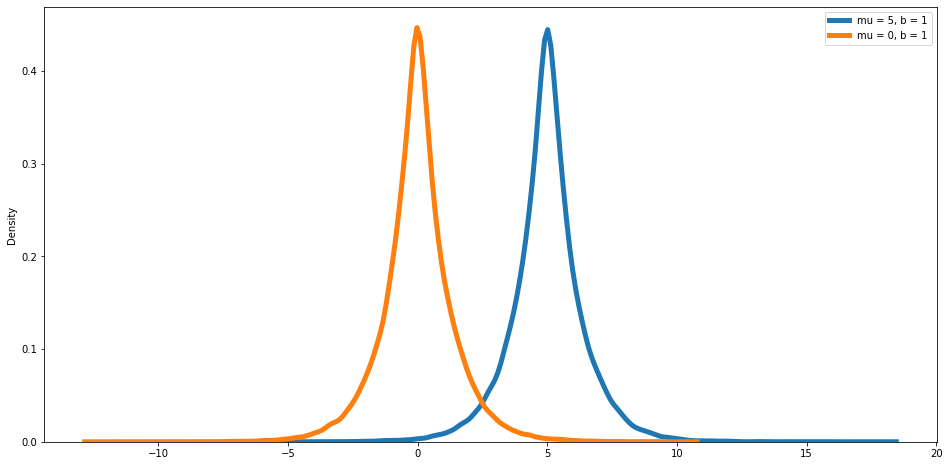

In [45]:
plt.figure(figsize=(16,8))
sns.kdeplot(np.random.laplace(loc=5, scale=1, size=50000),
            label='mu = 5, b = 1', linewidth=5)
sns.kdeplot(np.random.laplace(loc=0, scale=1, size=50000), 
            label='mu = 0, b = 1', linewidth=5)
# plt.xticks(range(10))
# plt.vlines(5,0,.4, color='red')
# plt.vlines(4,0,.4, color='red')
plt.legend()
plt.show()

```{bibliography}
```

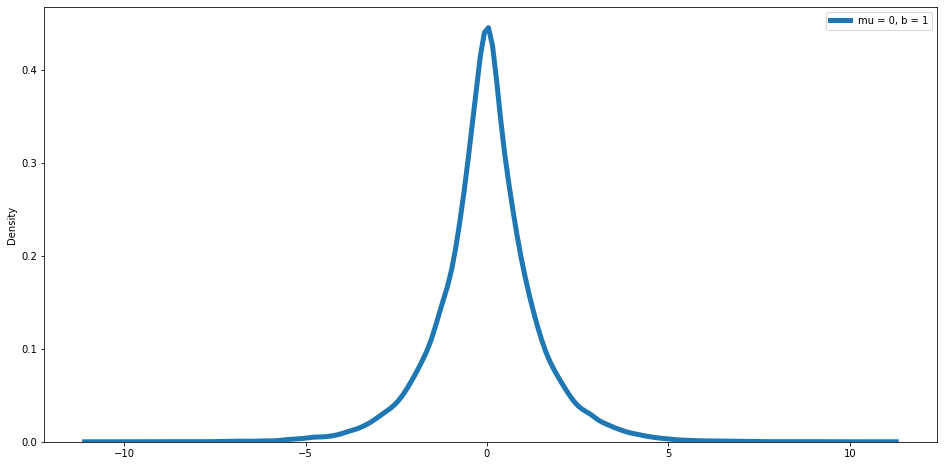

In [43]:
plt.figure(figsize=(16,8))
sns.kdeplot(np.random.laplace(loc=0, scale=1, size=50000), 
            label='mu = 0, b = 1', linewidth=5)
plt.legend()
plt.show()

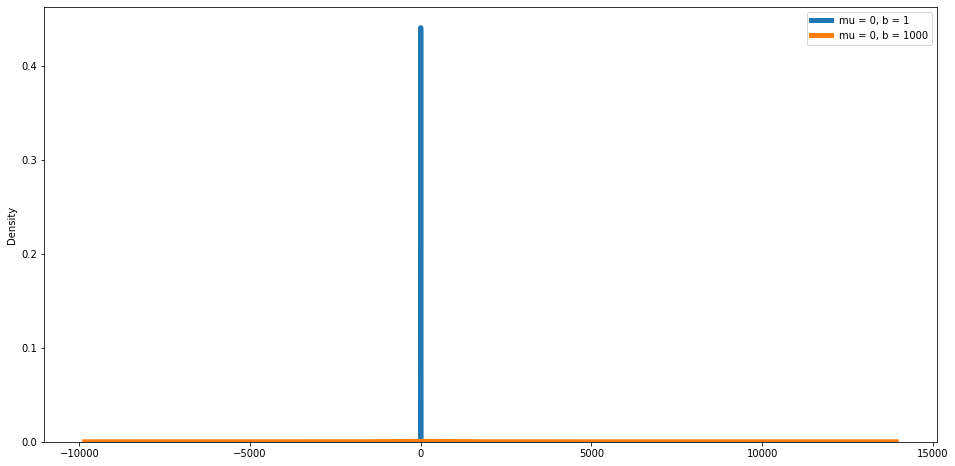

In [46]:
plt.figure(figsize=(16,8))
sns.kdeplot(np.random.laplace(loc=0, scale=1, size=50000), 
            label='mu = 0, b = 1', linewidth=5)
sns.kdeplot(np.random.laplace(loc=0, scale=1000, size=50000), 
            label='mu = 0, b = 1000',linewidth=5)
# plt.yscale('log')
plt.legend()
plt.show()

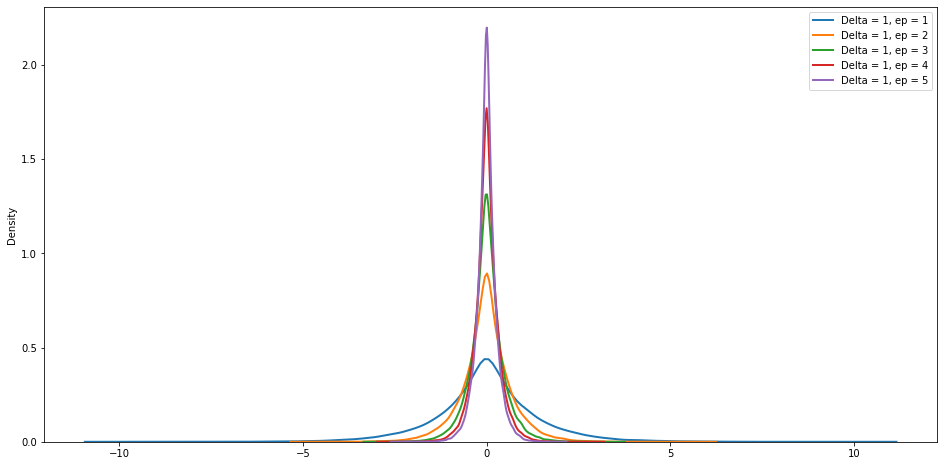

In [51]:
plt.figure(figsize=(16,8))
for i in range(1,6):
    sns.kdeplot(np.random.laplace(loc=0, scale=1/i, size=50000), 
            label='Delta = 1, ep = {}'.format(i),linewidth=2)
# plt.yscale('log')
plt.legend()
plt.show()